In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import torch
import torch.nn as nn

# sys.path.append("/home/avalocal/thesis23/MIM-Depth-Estimation")
from torch.utils.data import DataLoader
from torchvision import transforms
# from transformations import *

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

from dataset.cityscapes import cityscapes, create_filenames
from dataloader import CityScapesDataset

from collections import OrderedDict
import torch.backends.cudnn as cudnn


# from mmcv.cnn import (build_conv_layer, build_norm_layer, build_upsample_layer,
#                       constant_init, normal_init)

from mmcv.cnn import build_conv_layer, build_norm_layer, build_upsample_layer
from mmengine.model import constant_init, normal_init

from models.swin_transformer_v2 import SwinTransformerV2

from models.modelMulti import GLPDepth



In [2]:
# create filnames
splits = ["train", "val", "test"]
for split in splits:
    create_filenames("/home/data/cityscapes", split)

In [3]:
# BATCH_SIZE = 16
# DEVICE=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# root = "/home/data/cityscapes"

# test_transform = transforms.Compose([
#     ToTensor(),
#     Normalize(),
# ])


In [4]:
root = "/home/data/cityscapes"
filenames_path = os.path.join(root, "filenames")

test_dataset = cityscapes(root, filenames_path=filenames_path, split='test', crop_size=(448, 576), scale_size=None)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=False)
NUM_SEG_CLASSES = 20

val_dataset=cityscapes(root, filenames_path=filenames_path,  split='val', crop_size=(448, 576), scale_size=None)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=False)
val_dataset_size = len(val_dataset)

train_dataset=cityscapes(root, filenames_path=filenames_path,  split='train', crop_size=(448, 576), scale_size=None)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=False)
train_dataset_size = len(train_dataset)

Dataset: cityscapes Depth
# of  test images: 1525
Dataset: cityscapes Depth
# of val images: 500
Dataset: cityscapes Depth
# of train images: 2975


In [5]:
dataset = 'cityscapes'
data_path= '/home/data/cityscapes'
max_depth = 80
max_depth_eval = 80
backbone = 'swin_base_v2'
depths = [ 2, 2, 18, 2]
num_filters = [32,32,32]
deconv_kernels=[2,2,2]
window_size = [22, 22,22,11]
pretrain_window_size = [12, 12, 12, 6]
use_shift=[ True, True, False, False]
shift_size= 16
save_visualization = False
#ckpt_dir ='/home/avalocal/thesis23/MIM-Depth-Estimation/logs/2024-01-09_13-26-44_cityscapes_4_epoch_200_model_deconv3_32_2_480_480_00005_3e-05_09_005_200_22_22_22_11_2_2_18_2/epoch_120_model.ckpt'
#ckpt_dir='/home/avalocal/thesis23/MIM-Depth-Estimation/logs/2024-01-21_11-00-31_cityscapes_4_swin_v2_base_simmim_deconv3_32_2_480_480_00005_3e-05_09_005_200_22_22_22_11_2_2_18_2/epoch_200_model.ckpt'
# ckpt_dir = '/home/avalocal/thesis23/MIM-Depth-Estimation/logs/2024-01-21_11-00-31_cityscapes_4_swin_v2_base_simmim_deconv3_32_2_480_480_00005_3e-05_09_005_200_22_22_22_11_2_2_18_2/epoch_200_model.ckpt'
ckpt_dir = '/home/workspace/SwinMTL/ckpt/cityscapes480.ckpt'
flip_test= False
shift_window_test= False
num_classes = 20
drop_path_rate = 0.3
use_checkpoint = True
num_deconv = 3
pretrained="/home/workspace/SwinMTL/weights/swin_v2_base_simmim.pth"


In [6]:
def load_model(ckpt, model, optimizer=None):
    ckpt_dict = torch.load(ckpt, map_location='cpu')

    state_dict = ckpt_dict['model']
    weights = {}
    for key, value in state_dict.items():
        if key.startswith('module.'):
            weights[key[len('module.'):]] = value
        else:
            weights[key] = value
    #print(weights.keys(), 'loaded...')
    model.load_state_dict(weights)


    if optimizer is not None:
        optimizer_state = ckpt_dict['optimizer']
        optimizer.load_state_dict(optimizer_state)
    #print(ckpt, 'loaded....')

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

args = lambda: None
args.max_depth = 80
args.backbone = 'swin_base_v2'
args.depths = [2, 2, 18, 2]
args.num_filters = [32, 32, 32]
args.deconv_kernels = [2, 2, 2]
args.window_size = [22, 22, 22, 11]
args.pretrain_window_size = [12, 12, 12, 6]
args.use_shift = [True, True, False, False]
args.shift_size = 16
args.save_visualization = False
args.flip_test = False
args.shift_window_test = False
args.num_classes = 20
args.drop_path_rate = 0.3
args.pretrained = "/home/workspace/SwinMTL/weights/swin_v2_base_simmim.pth"
args.save_model = False
args.crop_h = 224
args.crop_w = 224
args.layer_decay = 0.9
args.use_checkpoint = True
args.num_deconv = 3

model = GLPDepth(args=args).to(device)
load_model(ckpt_dir, model)

model.eval()

#number of parameters in millions
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params = pytorch_total_params/1000000
print("number of parameters: ", pytorch_total_params, "M")







In [8]:
sample = val_dataset[220] 
img, depth, seg = sample['image'], sample['depth'], sample['seg']

In [9]:
torch.cuda.empty_cache()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred_depth = pred['pred_d'].squeeze(0).squeeze(0)
    pred_seg = pred['pred_seg'].squeeze(0) #20, 224, 320
    pred_seg = torch.argmax(pred_seg, dim=0)
    

/home/conda/envs/prc/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [10]:
from labels import labels

def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)
    return image


def get_color_mask(mask, labels, id_type='id'):
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    if id_type == 'id':
        for lbl in labels:
            color_mask[mask == lbl.id] = lbl.color
    elif id_type == 'trainId':
        for lbl in labels:
            if (lbl.trainId != 255) | (lbl.trainId != -1):
                color_mask[mask == lbl.trainId] = lbl.color
    return color_mask


def plot_items(left, mask, depth, labels=None, num_seg_labels=20, id_type='trainId'):
    left = convert_to_numpy(left)   
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))

    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)

        ax[1].imshow(color_mask)
    else:
        print("wrong")
    ax[1].set_title("Seg Mask")

    ax[2].imshow(depth, cmap='inferno_r')
    ax[2].set_title("Depth")

In [11]:
depth.min(), depth.max(), pred_depth.min(), pred_depth.max()

(tensor(0.),
 tensor(80.),
 tensor(6.9108, device='cuda:0'),
 tensor(79.8877, device='cuda:0'))

(tensor(80.), tensor(0.))

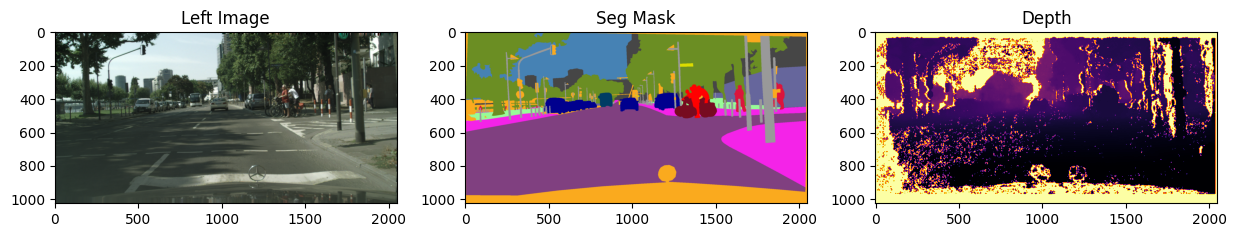

In [15]:
#plot ground truth
plot_items(img, seg, depth, labels=labels, num_seg_labels=20, id_type='trainId')
depth.max(), depth.min()


(tensor(79.8877, device='cuda:0'), tensor(6.9108, device='cuda:0'))

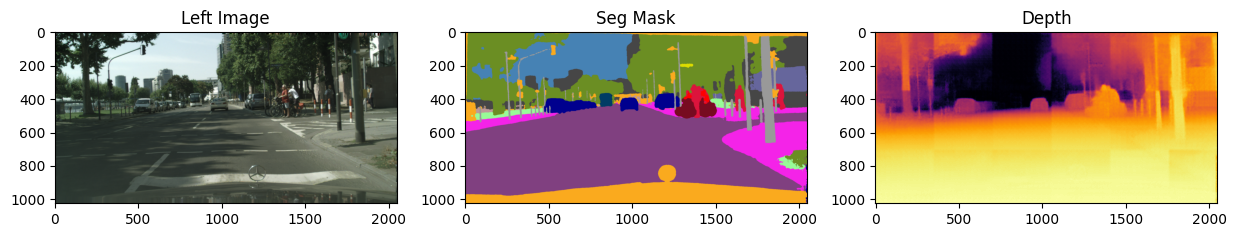

In [16]:
#plot prediction
plot_items(img, pred_seg, pred_depth, labels=labels, num_seg_labels=20, id_type='trainId')
pred_depth.max(), pred_depth.min()

In [28]:
from utils.metrics import eval_depth, cropping_img_v2
from tqdm import tqdm

results = []
for batch in tqdm(val_loader):
    img, depth, seg = batch['image'], batch['depth'], batch['seg']
    img = img.to(device)
    depth = depth.to(device)
    with torch.no_grad():
        pred = model(img)
        pred_depth = pred['pred_d'].squeeze(0)
        pred_seg = pred['pred_seg'].squeeze(0)
        pred_seg = torch.argmax(pred_seg, dim=0)
        results.append(eval_depth(*cropping_img_v2(pred_depth, depth, max_depth_eval=128)))


  0%|          | 0/500 [00:00<?, ?it/s]

/home/conda/envs/prc/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 500/500 [04:08<00:00,  2.01it/s]


In [29]:
# List of keys to calculate the mean
keys = ['abs_rel', 'sq_rel', 'rmse', 'rmse_log', 'd1', 'd2', 'd3']

# Initialize a dictionary to store the sum of each key
sums = {key: 0 for key in keys}

# Initialize a counter for the number of dictionaries
count = len(results)

# Calculate the sum for each key
for result in results:
    for key in keys:
        sums[key] += result[key]

# Calculate the mean for each key
means = {key: sums[key] / count for key in keys}

from pprint import pprint
pprint(means)

{'abs_rel': 0.5953755138516426,
 'd1': 0.1377921517783543,
 'd2': 0.2727113506537862,
 'd3': 0.34301536151021716,
 'rmse': 49.600167999267576,
 'rmse_log': 1.3584824385643006,
 'sq_rel': 32.44285194015503}


In [17]:
#Create Voxel Map
#depth image to point cloud
import numpy as np
import open3d as o3d
import cv2

depth_map=depth.cpu().numpy()
depth_map = depth_map 
dmin = 1e-3
dmax = 80.0
depth_map = dmin * np.exp(np.log((dmax / dmin)) * depth_map) 


img_=img.detach().cpu().numpy().transpose(1, 2, 0)
seg_map=seg.cpu().numpy()

#read label image as gray
segs=seg_map.reshape(-1,1).astype(np.uint32)
voxel_colors = np.zeros((segs.shape[0], 3))


class2color ={
    0: [128, 64,128], # road
    1: [244, 35,232], # sidewalk
    2: [70, 70, 70], # building
    3: [102,102,156], # wall
    4: [190,153,153], # fence
    5: [153,153,153], # pole
    6: [250,170, 30], # traffic light
    7: [220,220,  0], # traffic sign
    8: [107,142, 35], # vegetation
    9: [152,251,152], # terrain
    10: [70,130,180], # sky
    11: [220, 20, 60],  # person
    12: [255,  0,  0], # rider
    13: [0,  0,142], # car
    14: [0,  0, 70], # truck
    15: [0, 60,100], # bus
    16: [0,  80,100],   # train
    17: [0,  0,230], # motorcycle
    18: [119, 11, 32], # bicycle
    19: [0,  0,0] # void
}


for i, label in enumerate(segs):
  voxel_colors[i]=class2color[label[0]]

W_orig, H_orig = 2048, 1024
w, h = 2048, 1024

# Intrinsic parameters for depth camera
fx_d = 2262.52 * w / W_orig
fy_d = 2265.3017905988554 * h / H_orig
cx_d = 1096.98 * w / W_orig
cy_d = 513.137 * h / H_orig

# Generate pixel grid
rows, cols = depth_map.shape
u, v = np.meshgrid(np.arange(cols), np.arange(rows))

# Calculate 3D coordinates
X = depth_map 
Y = - (u-cx_d)*depth_map/fx_d
Z = - (v-cy_d)*depth_map/fy_d

points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
points=points.astype(np.float32)
points_modify=points[points[:,2]<79] #remove points with depth>80
voxel_colors_modify=voxel_colors[points[:,2]<79]

# Flatten and stack the coordinates and colors
points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
points=points.astype(np.float32)
Vis=True
if Vis:
  # Create Open3D point cloud
  point_cloud = o3d.geometry.PointCloud()
  point_cloud.points = o3d.utility.Vector3dVector(points)
  point_cloud.colors = o3d.utility.Vector3dVector(voxel_colors/255)

  # Visualize the point cloud
  o3d.visualization.draw_geometries([point_cloud])



In [18]:
import numpy as np
import cv2
def create_birds_eye_view(points, labels, side_range=(-20, 20), fwd_range=(0, 80), res=1, min_height=-2, max_height=20):

    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]

    ff= (x_points > fwd_range[0]) & (x_points < fwd_range[1])
    ss= (y_points > side_range[0]) & (y_points < side_range[1])
    indices = np.argwhere(ff & ss).flatten()
    labels = labels[indices]

    x_img = (-y_points[indices] / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img = (-x_points[indices] / res).astype(np.int32)  # y axis is -x in LIDAR

    x_img -= int(np.floor(side_range[0] / res))
    y_img += int(np.floor(fwd_range[1] / res))

    pixel_values = np.clip(z_points[indices] , min_height, max_height)
    pixel_values = ((pixel_values- min_height)/(max_height-min_height) * 255).astype(np.uint8)

    x_max = int((side_range[1] - side_range[0]) / res)
    y_max = int((fwd_range[1] - fwd_range[0]) / res)

    img = np.zeros([y_max, x_max], dtype=np.uint8)
    label_img = np.zeros([y_max, x_max, 3], dtype=np.uint8)
    combined_img = np.zeros([y_max, x_max, 3], dtype=np.uint8)

    img[y_img, x_img] = pixel_values
    label_img[y_img, x_img] = labels
    pixel_colors = plt.get_cmap('jet')(pixel_values / 255)[:, :3] * 255 #(n, 3)
    for i in range(3):

        combined_img[y_img, x_img, i] = 0.8 * pixel_colors[:, i] + 0.2 * labels[:, i]


    fig, axes = plt.subplots(1, 2, figsize=(15, 15))

    axes[0].imshow(label_img)
    axes[0].set_title('Labels')

    axes[1].imshow(combined_img)
    axes[1].set_title('Combined')

    
    plt.show()



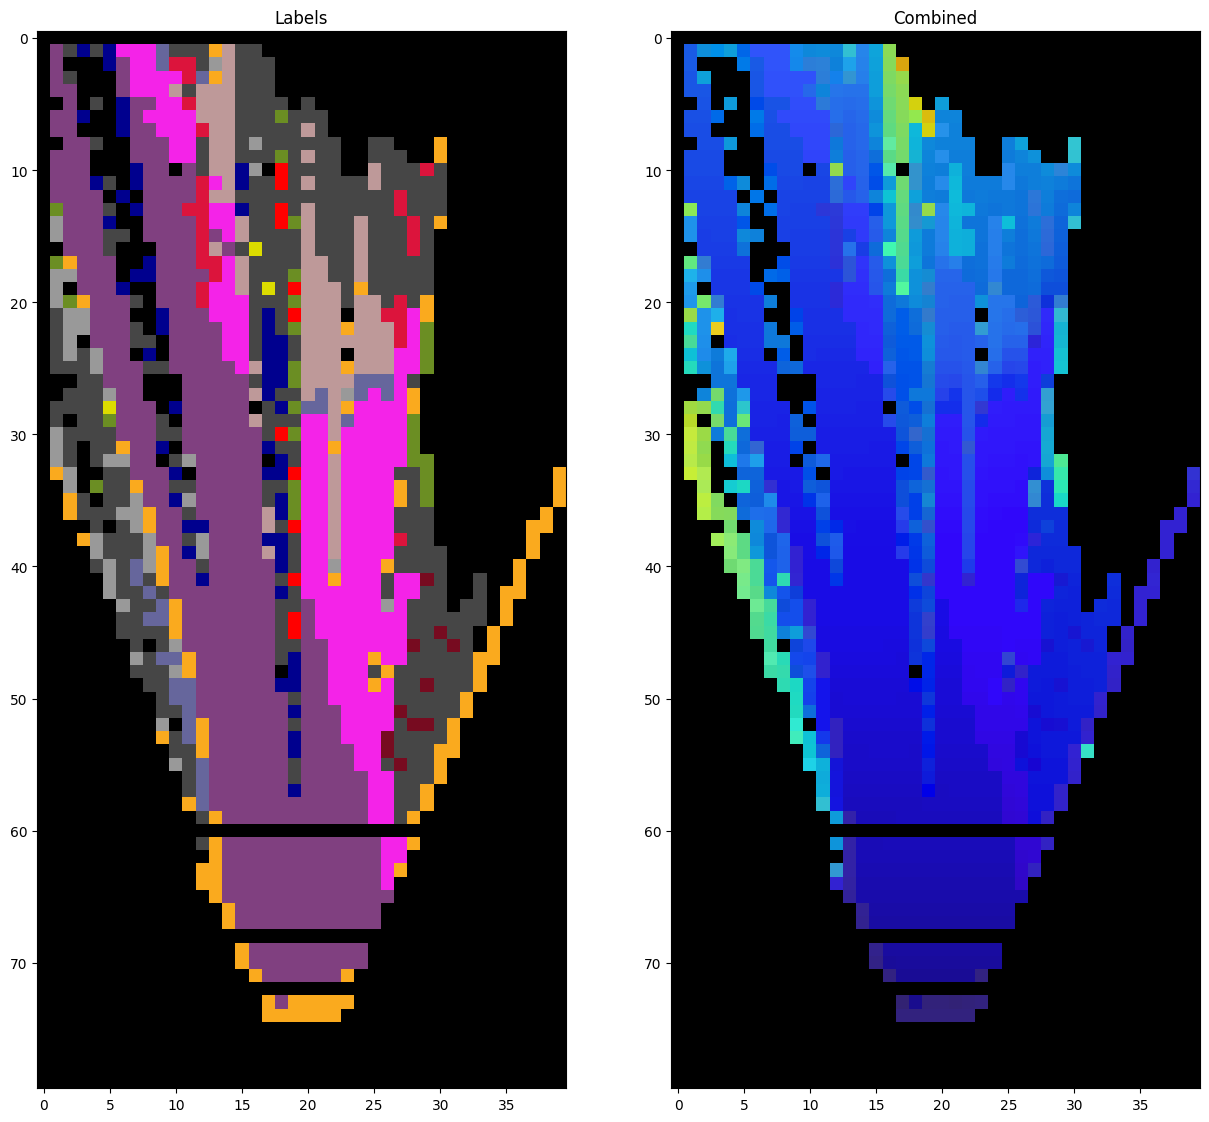

In [24]:
create_birds_eye_view(points, voxel_colors)


### KITTI DATASET

In [38]:
from dataset.kitti import kitti
root = "/home/avalocal/perception_system/datasets/kitti"
test_dataset = kitti(root, filenames_path='./dataset/filenames/', is_train=False, dataset='kitti', crop_size=(352, 1216), scale_size=None)


Dataset : kitti
# of test images: 438


In [39]:
dataset = 'kitti'
data_path= '/home/avalocal/Perception_system/datasets/kitti'
max_depth = 80
max_depth_eval = 80
backbone = 'swin_base_v2'
depths = [ 2, 2, 18, 2]
num_filters = [32,32,32]
deconv_kernels=[2,2,2]
window_size = [22, 22,22,11]
pretrain_window_size = [12, 12, 12, 6]
use_shift=[ True, True, False, False]
shift_size= 16
save_visualization = False
#ckpt_dir ='/home/avalocal/thesis23/MIM-Depth-Estimation/logs/2024-01-09_13-26-44_cityscapes_4_epoch_200_model_deconv3_32_2_480_480_00005_3e-05_09_005_200_22_22_22_11_2_2_18_2/epoch_120_model.ckpt'
#ckpt_dir='/home/avalocal/thesis23/MIM-Depth-Estimation/logs/2024-01-21_11-00-31_cityscapes_4_swin_v2_base_simmim_deconv3_32_2_480_480_00005_3e-05_09_005_200_22_22_22_11_2_2_18_2/epoch_200_model.ckpt'
ckpt_dir = '/home/avalocal/thesis23/MIM-Depth-Estimation/logs/2024-01-21_11-00-31_cityscapes_4_swin_v2_base_simmim_deconv3_32_2_480_480_00005_3e-05_09_005_200_22_22_22_11_2_2_18_2/epoch_200_model.ckpt'
flip_test= False
shift_window_test= False
num_classes = 20
drop_path_rate = 0.3
use_checkpoint = True
num_deconv = 3
pretrained="/home/avalocal/thesis23/MIM-Depth-Estimation/weights/swin_v2_base_simmim.pth"


In [40]:
torch.cuda.empty_cache()
import cv2
to_tensor = transforms.ToTensor() 
sample = test_dataset[40]  
img = sample['image']
img= cv2.resize(img, (2048, 1024))
img = to_tensor(img)
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred_depth = pred['pred_d'].squeeze(0).squeeze(0)
    pred_seg = pred['pred_seg'].squeeze(0) 
    pred_seg = torch.argmax(pred_seg, dim=0)


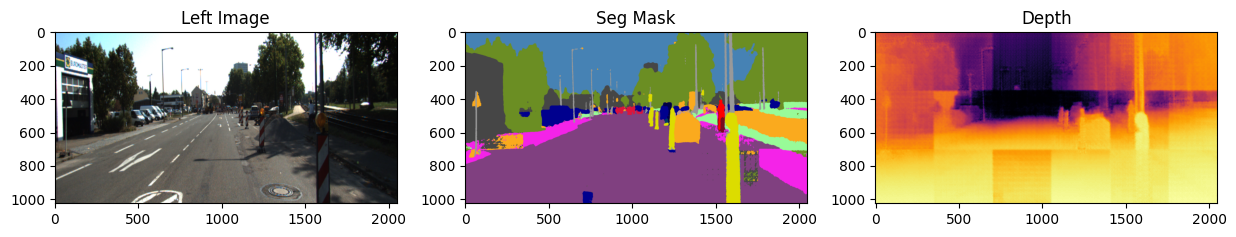

In [41]:
plot_items(img, pred_seg, pred_depth, labels=labels, num_seg_labels=20, id_type='trainId')


In [ ]:
#run to save predictions 

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision import transforms


def save_predictions(image_folder, model, device):

    #images = os.listdir(image_folder)
    count = 0
    depth_folder="/home/avalocal/thesis23/MIM-Depth-Estimation/results/depth_kitti/"
    seg_folder="/home/avalocal/thesis23/MIM-Depth-Estimation/results/seg_kitti/"
    to_tensor = transforms.ToTensor()
    for x in test_dataset:
        image = x['image']
        img = cv2.resize(image, (2048, 1024))
        img = to_tensor(img)
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_depth = pred['pred_d'].squeeze(0).squeeze(0)
            pred_seg = pred['pred_seg'].squeeze(0) 
            pred_seg = torch.argmax(pred_seg, dim=0)
        #save depth
        depth_path = os.path.join(depth_folder, str(count)+'.png')
        pred_depth = convert_to_numpy(pred_depth)
        pred_depth = (pred_depth - np.min(pred_depth)) / (np.max(pred_depth) - np.min(pred_depth))
        pred_depth = (pred_depth * 255).astype(np.uint8)
        #cmap inferno_r
        plt.imsave(depth_path, pred_depth, cmap='inferno_r')
        #save seg
        seg_path = os.path.join(seg_folder, str(count)+'.png')
        pred_seg = convert_to_numpy(pred_seg)
        color_mask = get_color_mask(pred_seg, labels, 'trainId')
        plt.imsave(seg_path, color_mask)
        
        
        count+=1

In [ ]:
img_folder="/home/avalocal/perception_system/datasets/kitti/2011_09_26/2011_09_26_drive_0051_sync/image_03/data"
save_predictions(img_folder, model, device)

In [ ]:
#create a video from the images 
import cv2
import os

def create_video_from_images(image_folder, video_name, fps):

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('.')[0]))
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, _ = 1024, 2048, 3
    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:

        image_path = os.path.join(image_folder, image)
        frame= cv2.resize(cv2.imread(image_path), (width, height))
        out.write(frame) # Write out frame to video

        cv2.imshow('video', frame)
        if (cv2.waitKey(100) & 0xFF) == ord('q'):
            break
        
    cv2.destroyAllWindows()
    out.release()

In [ ]:
img_folder="/home/avalocal/perception_system/datasets/kitti/2011_09_26/2011_09_26_drive_0051_sync/image_03/data"
depth_folder="/home/avalocal/thesis23/MIM-Depth-Estimation/results/depth_kitti"
seg_folder="/home/avalocal/thesis23/MIM-Depth-Estimation/results/seg_kitti"

video_name = "/home/avalocal/thesis23/MIM-Depth-Estimation/results/videos/kitti_video.mp4"
video_name_depth = "/home/avalocal/thesis23/MIM-Depth-Estimation/results/videos/kitti_depth_video.mp4"
video_name_seg = "/home/avalocal/thesis23/MIM-Depth-Estimation/results/videos/kitti_seg_video.mp4"

##choose one of the following to create a video from the saved images
#create_video_from_images(img_folder, video_name, 10)
#create_video_from_images(depth_folder, video_name_depth, 10)
#create_video_from_images(seg_folder, video_name_seg, 10)